In [15]:
import numpy as np
import featuretools as ft
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost
from xgboost.sklearn import XGBClassifier

In [16]:
train_df = pd.read_csv('input/train.csv', na_values=['NAN','NA','NaN','na','nan'])
test_df = pd.read_csv('input/test.csv', na_values=['NAN','NA','NaN','na','nan'])
X_all = pd.read_csv('input/X_all.csv', na_values=['NAN','NA','NaN','na','nan'])
X = pd.read_csv('input/X.csv', na_values=['NAN','NA','NaN','na','nan'])
X_test = pd.read_csv('input/X_test.csv', na_values=['NAN','NA','NaN','na','nan'])
ft_importance_total = pd.read_csv('input/ft_importance_total.csv', na_values=['NAN','NA','NaN','na','nan'])

In [17]:
train_df['OC'][train_df['OC'] == 'open'] = 0
train_df['OC'][train_df['OC'] == ' close'] = 1
y = train_df['OC']
X_id = train_df['inst_id']
X_test_id = test_df['inst_id']
X.fillna(X.median(), inplace=True)
X_test.fillna(X_test.median(), inplace=True)
y.fillna(0, inplace=True)
imbalanced_pos_ratio = y.value_counts()[1]/y.value_counts()[0]
imbalanced_pos_ratio

0.05244755244755245

In [46]:
def modelfit(alg, X, y, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgboost.DMatrix(X.values, label=y.values)
        cvresult = xgboost.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, stratified=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    #print(cvresult)
    #Fit the algorithm on the data
    #alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    #dtrain_predictions = alg.predict(dtrain[predictors])
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    #print "\nModel Report"
    #print "Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions)
    #print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob)
                    
    #feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    #feat_imp.plot(kind='bar', title='Feature Importances')
    #plt.ylabel('Feature Importance Score')
    return cvresult.shape[0], cvresult.iloc[cvresult.shape[0]-1, 0]*-1

In [47]:
xgb = XGBClassifier(
         learning_rate=0.1,
         n_estimators=500,
         objective= 'binary:logistic',
         tree_method='gpu_exact',
         predictor='gpu_predictor',
         scale_pos_weight=int(1/imbalanced_pos_ratio),
         seed=42)

In [48]:
min_metric = 100000
xgb_tunned_params = dict()
xgb_percentile = 0
for i in range(1,15):
    xgb_x_cols = ft_importance_total[ft_importance_total.value >= np.percentile(ft_importance_total.value,100-i)].sort_values(by='value', ascending=False).feature
    X2 = X[xgb_x_cols] 
    y2 = y.astype('int')
    v_n_estimators, v_metric = modelfit(xgb, X2, y2) 
    print('Iteration', i, 'estimators', v_n_estimators, 'percentile', 100-i, 'auc', v_metric)
    if v_metric < min_metric:
        xgb_tunned_params['n_estimators'] = v_n_estimators
        xgb_percentile = 100-i
        min_metric = v_metric
print('Best params', xgb_tunned_params, 'percentile', xgb_percentile, 'auc', min_metric)

Iteration 1 estimators 9 percentile 99 auc -0.8809942000000002
Iteration 2 estimators 9 percentile 98 auc -0.8681994
Iteration 3 estimators 9 percentile 97 auc -0.8406938
Iteration 4 estimators 9 percentile 96 auc -0.7846138
Iteration 5 estimators 9 percentile 95 auc -0.7898569999999999
Iteration 6 estimators 9 percentile 94 auc -0.7635812
Iteration 7 estimators 9 percentile 93 auc -0.7306916
Iteration 8 estimators 9 percentile 92 auc -0.728413
Iteration 9 estimators 9 percentile 91 auc -0.7295018
Iteration 10 estimators 9 percentile 90 auc -0.7260333999999999
Iteration 11 estimators 9 percentile 89 auc -0.7260333999999999
Iteration 12 estimators 9 percentile 88 auc -0.7260333999999999
Iteration 13 estimators 9 percentile 87 auc -0.7248638
Iteration 14 estimators 9 percentile 86 auc -0.7254486
Best params {'n_estimators': 9} percentile 99 auc -0.8809942000000002


In [62]:
xgb_x_cols = ft_importance_total[ft_importance_total.value >= np.percentile(ft_importance_total.value,xgb_percentile)].sort_values(by='value', ascending=False).feature
xgb_x_cols

933                      employee1_enc
934                      employee2_enc
930                           sido_enc
113    DIFF(shortLoan1 by ownerChange)
935                    ownerChange_enc
0                                 noi1
149       DIFF(profit2 by ownerChange)
154         DIFF(bedCount by instkind)
186          DIFF(noe1 by ownerChange)
93                     inventoryAsset2
Name: feature, dtype: object

In [63]:
xgb = XGBClassifier(
         learning_rate=0.1,
         n_estimators=xgb_tunned_params['n_estimators'],
         objective= 'binary:logistic',
         tree_method='gpu_exact',
         predictor='gpu_predictor',
         scale_pos_weight=int(1/imbalanced_pos_ratio),
         seed=42)

In [64]:
xgb.fit(X[xgb_x_cols], y.astype(int))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=9,
       n_jobs=1, nthread=None, objective='binary:logistic',
       predictor='gpu_predictor', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=19, seed=42, silent=True,
       subsample=1, tree_method='gpu_exact')

In [65]:
preds_class = xgb.predict(X_test[xgb_x_cols])
preds_proba = xgb.predict_proba(X_test[xgb_x_cols])

In [66]:
preds_class

array([0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1])

In [67]:
preds_proba[:,1]

array([0.41178006, 0.37298074, 0.63293976, 0.63346916, 0.34526142,
       0.60507226, 0.60507226, 0.60507226, 0.60507226, 0.60507226,
       0.37298074, 0.63293976, 0.41178006, 0.60507226, 0.60507226,
       0.34526142, 0.34526142, 0.60507226, 0.37244782, 0.44124085,
       0.567644  , 0.60507226, 0.63293976, 0.567644  , 0.41178006,
       0.60507226, 0.44124085, 0.41178006, 0.60507226, 0.44124085,
       0.60507226, 0.44124085, 0.41178006, 0.41178006, 0.60507226,
       0.60507226, 0.41178006, 0.60507226, 0.41178006, 0.60507226,
       0.37298074, 0.60507226, 0.60507226, 0.63346916, 0.34526142,
       0.60507226, 0.60507226, 0.37298074, 0.74182993, 0.63346916,
       0.60507226, 0.34526142, 0.74182993, 0.60507226, 0.60507226,
       0.63346916, 0.60507226, 0.60507226, 0.44124085, 0.41178006,
       0.60507226, 0.34526142, 0.60507226, 0.74182993, 0.60507226,
       0.63346916, 0.34526142, 0.74182993, 0.60507226, 0.60507226,
       0.60507226, 0.60507226, 0.60507226, 0.34526142, 0.37298

In [68]:
from sklearn.model_selection import train_test_split

In [69]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X[xgb_x_cols], y, test_size=0.33, random_state=42)

In [70]:
xgb = XGBClassifier(
         learning_rate=0.1,
         n_estimators=xgb_tunned_params['n_estimators'],
         objective= 'binary:logistic',
         tree_method='gpu_exact',
         predictor='gpu_predictor',
         scale_pos_weight=int(1/imbalanced_pos_ratio),
         seed=42)

In [71]:
xgb.fit(X_train1, y_train1.astype(int))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=9,
       n_jobs=1, nthread=None, objective='binary:logistic',
       predictor='gpu_predictor', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=19, seed=42, silent=True,
       subsample=1, tree_method='gpu_exact')

In [72]:
preds_class = xgb.predict(X_test1)
preds_proba = xgb.predict_proba(X_test1)

In [73]:
from sklearn.metrics import confusion_matrix

In [74]:
confusion_matrix(y_test1, preds_class)

array([[90,  4],
       [ 5,  1]], dtype=int64)

Text(0.5,12.5,'Predicted label')

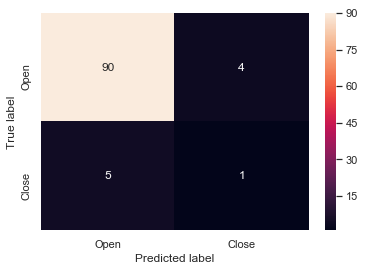

In [79]:
df_cm = pd.DataFrame(
        confusion_matrix(y_test1, preds_class), index=['Open','Close'], columns=['Open','Close'], 
    )
fig = plt.figure()
try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
plt.ylabel('True label')
plt.xlabel('Predicted label')